<a href="https://colab.research.google.com/github/Vaincookie/FundamentalAnalysis/blob/master/Transformer_true_predict_compare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install pytorch_lightning
import pytorch_lightning as pl
import torch
import torch.nn as nn
from torch.nn import Linear
'''
我们将使用的模型是一个编码器-解码器的Transformer，其中编码器部分将时间序列的历史作为输入，而解码器部分以自回归的方式预测未来的值。

解码器使用注意力机制与编码器连接。通过这种方式，解码器可以学习在做出预测之前“关注”时间序列历史值中最有用的部分。

解码器使用了掩蔽的自注意力，这样网络就不会在训练期间获取未来的值，不会导致信息的泄露。
https://zhuanlan.zhihu.com/p/372668675
'''

def smape_loss(y_pred, target):
    loss = 2 * (y_pred - target).abs() / (y_pred.abs() + target.abs() + 1e-8)
    return loss.mean()


def gen_trg_mask(length, device):
    mask = torch.tril(torch.ones(length, length, device=device)) == 1

    mask = (
        mask.float()
        .masked_fill(mask == 0, float("-inf"))
        .masked_fill(mask == 1, float(0.0))
    )

    return mask


class TimeSeriesForcasting(nn.Module):
    def __init__(
        self,
        n_encoder_inputs,
        n_decoder_inputs,
        channels=128,
        dropout=0.1,
        lr=1e-5,
    ):
        super().__init__()


        self.lr = lr
        self.dropout = dropout

        self.input_pos_embedding = torch.nn.Embedding(1024, embedding_dim=channels)
        self.target_pos_embedding = torch.nn.Embedding(1024, embedding_dim=channels)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=channels,
            nhead=8,
            dropout=self.dropout,
            dim_feedforward=4 * channels,
        )
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=channels,
            nhead=8,
            dropout=self.dropout,
            dim_feedforward=4 * channels,
        )

        self.encoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=8)
        self.decoder = torch.nn.TransformerDecoder(decoder_layer, num_layers=8)

        self.input_projection = Linear(n_encoder_inputs, channels)
        self.output_projection = Linear(n_decoder_inputs, channels)

        self.linear = Linear(channels, 1)

        self.do = nn.Dropout(p=self.dropout)

    def encode_src(self, src):
        src_start = self.input_projection(src).permute(1, 0, 2)

        in_sequence_len, batch_size = src_start.size(0), src_start.size(1)
        pos_encoder = (
            torch.arange(0, in_sequence_len, device=src.device)
            .unsqueeze(0)
            .repeat(batch_size, 1)
        )

        pos_encoder = self.input_pos_embedding(pos_encoder).permute(1, 0, 2)

        src = src_start + pos_encoder

        src = self.encoder(src) + src_start

        return src

    def decode_trg(self, trg, memory):

        trg_start = self.output_projection(trg).permute(1, 0, 2)

        out_sequence_len, batch_size = trg_start.size(0), trg_start.size(1)

        pos_decoder = (
            torch.arange(0, out_sequence_len, device=trg.device)
            .unsqueeze(0)
            .repeat(batch_size, 1)
        )
        pos_decoder = self.target_pos_embedding(pos_decoder).permute(1, 0, 2)

        trg = pos_decoder + trg_start

        trg_mask = gen_trg_mask(out_sequence_len, trg.device)

        out = self.decoder(tgt=trg, memory=memory, tgt_mask=trg_mask) + trg_start

        out = out.permute(1, 0, 2)

        out = self.linear(out)

        return out

    def forward(self, x):
        src, trg = x

        src = self.encode_src(src)

        out = self.decode_trg(trg=trg, memory=src)

        return out


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# #!/usr/bin/python
# # -*- coding: UTF-8 -*-
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split
# import os
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import torch
# import torch.nn as nn
# from torch.autograd import Variable
# import torch.optim as optim
# import random
# import time
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import math
# from tqdm import trange
# from torch.utils.data import DataLoader, Dataset
# from torchvision import transforms
# import tensorflow as tf
# import matplotlib.pyplot as plt


# date=4200
# model_name = "Mini-Pytorch"
# torch.manual_seed(1)
# input_size = 7
# hidden_size = 1024
# output_size = 1
# epoch = 200
# lr = 1e-4
# seqs = 5
# dim_in = 7
# dim_out = 1
# time_steps = 5
# smoothing_window_size = 100

# for par in [0]:
#     for par2 in [50]:
#         smoothing_window_size = par2
#         time_steps = 5
#         date = 2000
#         product = "SQJT1125"
#         df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/min_600104data1129.csv")
#         df = df.drop(labels=['symbol', 'frequency', 'Unnamed: 0', 'eob', 'position', 'pre_close'], axis=1)
#         data = df.sort_values(['bob'], ascending=True)
#         # data = data[:-1]
#         data = data[par:]
#         data['mid'] = (data['high'].values + data['low'].values) / 2
#         data = data[['mid','open', 'high', 'low', 'close', 'volume', 'amount', 'bob']]
#         data = data.sort_values(['bob'], ascending=True)
#         data = data.drop(labels=['bob'], axis=1)
#         train_data = data[int(data.shape[0]*0.2):]
#         test_data = data[:int(data.shape[0] * 0.2)]
#         #draw
#         plt.rc('font', family='Youyuan', size='11')  # 和matplotlib一样指明字体
#         plt.rc('axes', unicode_minus='False')
#         pdseries = pd.Series(train_data['mid'].values)
#         plt.title('Train stock')  # 设置中文标题
#         pdseries.plot()
#         plt.show()

        
#         train_data = train_data.values.astype('float32')
#         test_data = test_data.values.astype('float32')
#         #entire fit
#         scaler = MinMaxScaler()
#         scaler.fit(train_data)
#         train_data = scaler.transform(train_data)
#         test_data = scaler.transform(test_data)


#         # 根据原始数据集构建矩阵
#         def create_dataset_trans(data, time_steps1,time_steps2,time_steps3):
#             dataX1, dataX2 ,dataY = [], [], []
#             for i in range(len(data) - (time_steps1+time_steps2+time_steps3-3)):
#               a = data[i:(i + time_steps1), :]
#               b = data[(i + time_steps1-1):(i + time_steps1+time_steps2-1), :]
#               c = data[(i + time_steps1+time_steps2-2):(i + time_steps1+time_steps2+time_steps3-2), 0:1]
#               dataX1.append(a)
#               dataX2.append(b)
#               dataY.append(c)
#             dataX1 = np.array(dataX1)
#             dataX2 = np.array(dataX2)
#             dataY = np.array(dataY)
#             return dataX1, dataX2 ,dataY 

#         trainX,trainX_decoder,trainY = create_dataset_trans(train_data,32,16,16)
#         testX,testX_decoder,testY = create_dataset_trans(test_data,32,16,16)

#         print('-' * 10 + 'train/test' + '-' * 10)
        
#         print("trainX:",trainX.shape)
#         print("trainX_decoder:",trainX_decoder.shape)
#         print("trainY:",trainY.shape)
        
#         print("testX:",testX.shape)
#         print("testX_decoder:",testX_decoder.shape)
#         print("testY:",testY.shape)
  
        
        
#         '''
#         ----------train/test----------
#         trainX: (26395, 5, 7)
#         trainX_decoder: (26395, 5, 6)
#         trainY: (26395, 5, 1)
        
#         testX: (6595, 5, 7)
#         testX_decoder: (6595, 5, 6)
#         testY: (6595, 5, 1)
        
        
        
#         '''


In [10]:
torch.cuda.empty_cache()

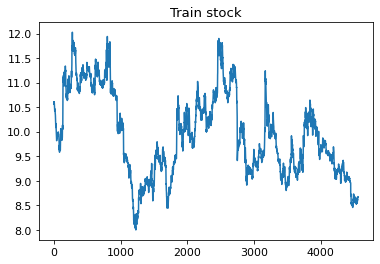

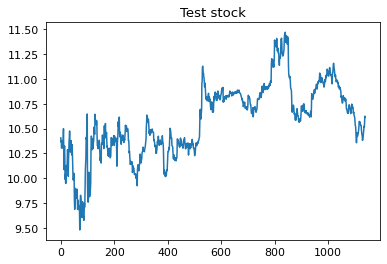

----------train/test----------
trainX: (4403, 128, 7)
trainX_decoder: (4403, 16, 6)
trainY: (4403, 16, 1)
testX: (983, 128, 7)
testX_decoder: (983, 16, 6)
testY: (983, 16, 1)
(4403, 128, 7)


100%|██████████| 2/2 [00:06<00:00,  3.37s/it]

Training Complete in 0m 7s


In [11]:
#!/usr/bin/python
# -*- coding: UTF-8 -*-
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import random
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from tqdm import trange
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import tensorflow as tf
import matplotlib.pyplot as plt


date=4200
model_name = "Mini-Pytorch"
torch.manual_seed(1)
input_size = 7
hidden_size = 1024
output_size = 1
epoch = 500
lr = 1e-4
seqs = 5
dim_in = 7
dim_out = 1
time_steps = 5
smoothing_window_size = 100

for par in [0]:
    for par2 in [50]:
        smoothing_window_size = par2
        time_steps = 5
        date = 2000
        product = "SQJT1125"
        df = pd.read_csv("/content/drive/MyDrive/Research_essay/hour_data.csv")
        df = df.drop(labels=['symbol', 'frequency', 'Unnamed: 0', 'eob', 'position', 'pre_close'], axis=1)
        data = df.sort_values(['bob'], ascending=True)
        # data = data[:-1]
        data = data[par:]
        data['mid'] = (data['high'].values + data['low'].values) / 2
        data = data[['mid','open', 'high', 'low', 'close', 'volume', 'amount', 'bob']]
        data = data.sort_values(['bob'], ascending=True)
        data = data.drop(labels=['bob'], axis=1)
        train_data = data[int(data.shape[0]*0.2):]
        test_data = data[:int(data.shape[0] * 0.2)]
        #draw
        plt.rc('font', family='Youyuan', size='11')  # 和matplotlib一样指明字体
        plt.rc('axes', unicode_minus='False')
        pdseries = pd.Series(train_data['mid'].values)
        plt.title('Train stock')  # 设置中文标题
        pdseries.plot()
        plt.show()

        plt.rc('font', family='Youyuan', size='11')  # 和matplotlib一样指明字体
        plt.rc('axes', unicode_minus='False')
        pdseries = pd.Series(test_data['mid'].values)
        plt.title('Test stock')  # 设置中文标题
        pdseries.plot()
        plt.show()

        train_data = train_data.values.astype('float32')
        test_data = test_data.values.astype('float32')
        #entire fit
        scaler = MinMaxScaler()
        scaler.fit(train_data)
        train_data = scaler.transform(train_data)
        test_data = scaler.transform(test_data)


        # 根据原始数据集构建矩阵
        def create_dataset_trans(data, time_steps1,time_steps2,time_steps3):
            dataX1, dataX2 ,dataY = [], [], []
            for i in range(len(data) - (time_steps1+time_steps2+time_steps3-3)):
              a = data[i:(i + time_steps1), :]
              b = data[(i + time_steps1-1):(i + time_steps1+time_steps2-1), 1:7]
              c = data[(i + time_steps1+time_steps2-2):(i + time_steps1+time_steps2+time_steps3-2), 0:1]
              dataX1.append(a)
              dataX2.append(b)
              dataY.append(c)
            dataX1 = np.array(dataX1)
            dataX2 = np.array(dataX2)
            dataY = np.array(dataY)
            return dataX1, dataX2 ,dataY 

        trainX,trainX_decoder,trainY = create_dataset_trans(train_data,128,16,16)
        testX,testX_decoder,testY = create_dataset_trans(test_data,128,16,16)

        print('-' * 10 + 'train/test' + '-' * 10)
        
        print("trainX:",trainX.shape)
        print("trainX_decoder:",trainX_decoder.shape)
        print("trainY:",trainY.shape)
        
        print("testX:",testX.shape)
        print("testX_decoder:",testX_decoder.shape)
        print("testY:",testY.shape)
  

        from torch.utils.data import TensorDataset
        import torch
        from torch.utils.data import DataLoader

        dl_train = DataLoader(TensorDataset(torch.tensor(trainX).float(), torch.tensor(trainY).float(), torch.tensor(trainX_decoder).float()),
                              shuffle=False, batch_size=128)
        dl_valid = DataLoader(TensorDataset(torch.tensor(testX).float(), torch.tensor(testY).float(), torch.tensor(testX_decoder).float()),
                              shuffle=False, batch_size=128)



        
        print(trainX.shape)
        bp = TimeSeriesForcasting(n_encoder_inputs=7, n_decoder_inputs=6)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        bp = bp.to(device)
        # summary(bp,input_size=(5,7),batch_size=-1)
        # trainx = trainX.to(device)
        # trainy = trainY.to(device)
        # testx = testX.to(device)
        # testy = testY.to(device)
        # trainX_decoder = trainX_decoder.to(device)
        # trainY_decoder = trainY_decoder.to(device)
        # testX_decoder = testX_decoder.to(device)
        # testY_decoder = testY_decoder.to(device)

        loss_function = nn.MSELoss()
        optimizer = optim.Adam(bp.parameters(), lr)

        list_x = []
        list_y = []
        list_ax = []
        list_ay = []

        begin = time.time()

        for epoch in trange(epoch):
            for batch_idx,(data_dl, target_dl, train_decoder_dl) in enumerate(dl_train):
                data_dl, target_dl, train_decoder_dl = data_dl.to(device) , target_dl.to(device), train_decoder_dl.to(device)
                # print(data_dl.shape)
                # print(target_dl.shape)
                # print(train_decoder_dl.shape)
                init_states = None
                output = bp((data_dl,train_decoder_dl))
                loss = loss_function(output, target_dl)
                running_loss = loss.item()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                Loss = []

                list_x.append(epoch)
                list_y.append(loss.item())

                # if epoch == 10:
                #     list_ax.append(epoch)
                #     list_ay.append(loss.item())
                #     plt.plot(list_x, list_y, color='r', linewidth=3)
                #     plt.scatter(list_ax, list_ay, marker='*', color='r')
                #     plt.show()

                # if epoch % 10 == 0:
                #     Loss.append(running_loss)
                #     print('Epoch: {}, Loss:{:.5f}, learning rate:{}'.format(epoch + 1, loss.item(), 1e-4))

        pass
        

        data_dl, target_dl, train_decoder_dl = data_dl.cpu() , target_dl.cpu(), train_decoder_dl.cpu()
        output = output.cpu()


        time_elapsed = time.time() - begin
        print('Training Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

        bp = bp.eval()

In [12]:

import gc
gc.collect()
torch.cuda.empty_cache()
result =[]
true =[]
for batch_idx, (test_dl, valid_dl, test_decoder_dl) in enumerate(dl_valid):
    init_states = None
    test_dl, valid_dl, test_decoder_dl = test_dl.to(device), valid_dl.to(device), test_decoder_dl.to(device)
    pre_output = bp((test_dl,test_decoder_dl))
    if(pre_output.shape[0]==128):
      for num in [0,15,31,47,63,79,95,111]:    
        result_iter = pre_output[num:num+1,:,:]
        result_iter =result_iter.cpu()
        result_iter = result_iter.data.numpy().reshape(pre_output.shape[1],1)
        for i in result_iter:
            result.append(i)
    
    else:
      re = pre_output.shape[0]//16
      for x in range(re+1):
        num = x*16
        result_iter = pre_output[num:num+1,:,:]
        result_iter =result_iter.cpu()
        result_iter = result_iter.data.numpy().reshape(pre_output.shape[1],1)
        for i in result_iter:
              result.append(i)
    print(len(result))
    true_iter = valid_dl[:, 0:1, :]
    true_iter = true_iter.cpu()
    true_iter = true_iter.data.numpy().reshape(true_iter.shape[0], 1)
    for i in true_iter:
        true.append(i)

    del test_dl, valid_dl, test_decoder_dl
    gc.collect() # 回收内存
    torch.cuda.empty_cache()

final_result = np.array(result)
print("final_result",final_result.shape)
true_y = np.array(true)
print("true_y",true_y.shape)

128
256
384
512
640
768
896
992
final_result (992, 1)
true_y (983, 1)


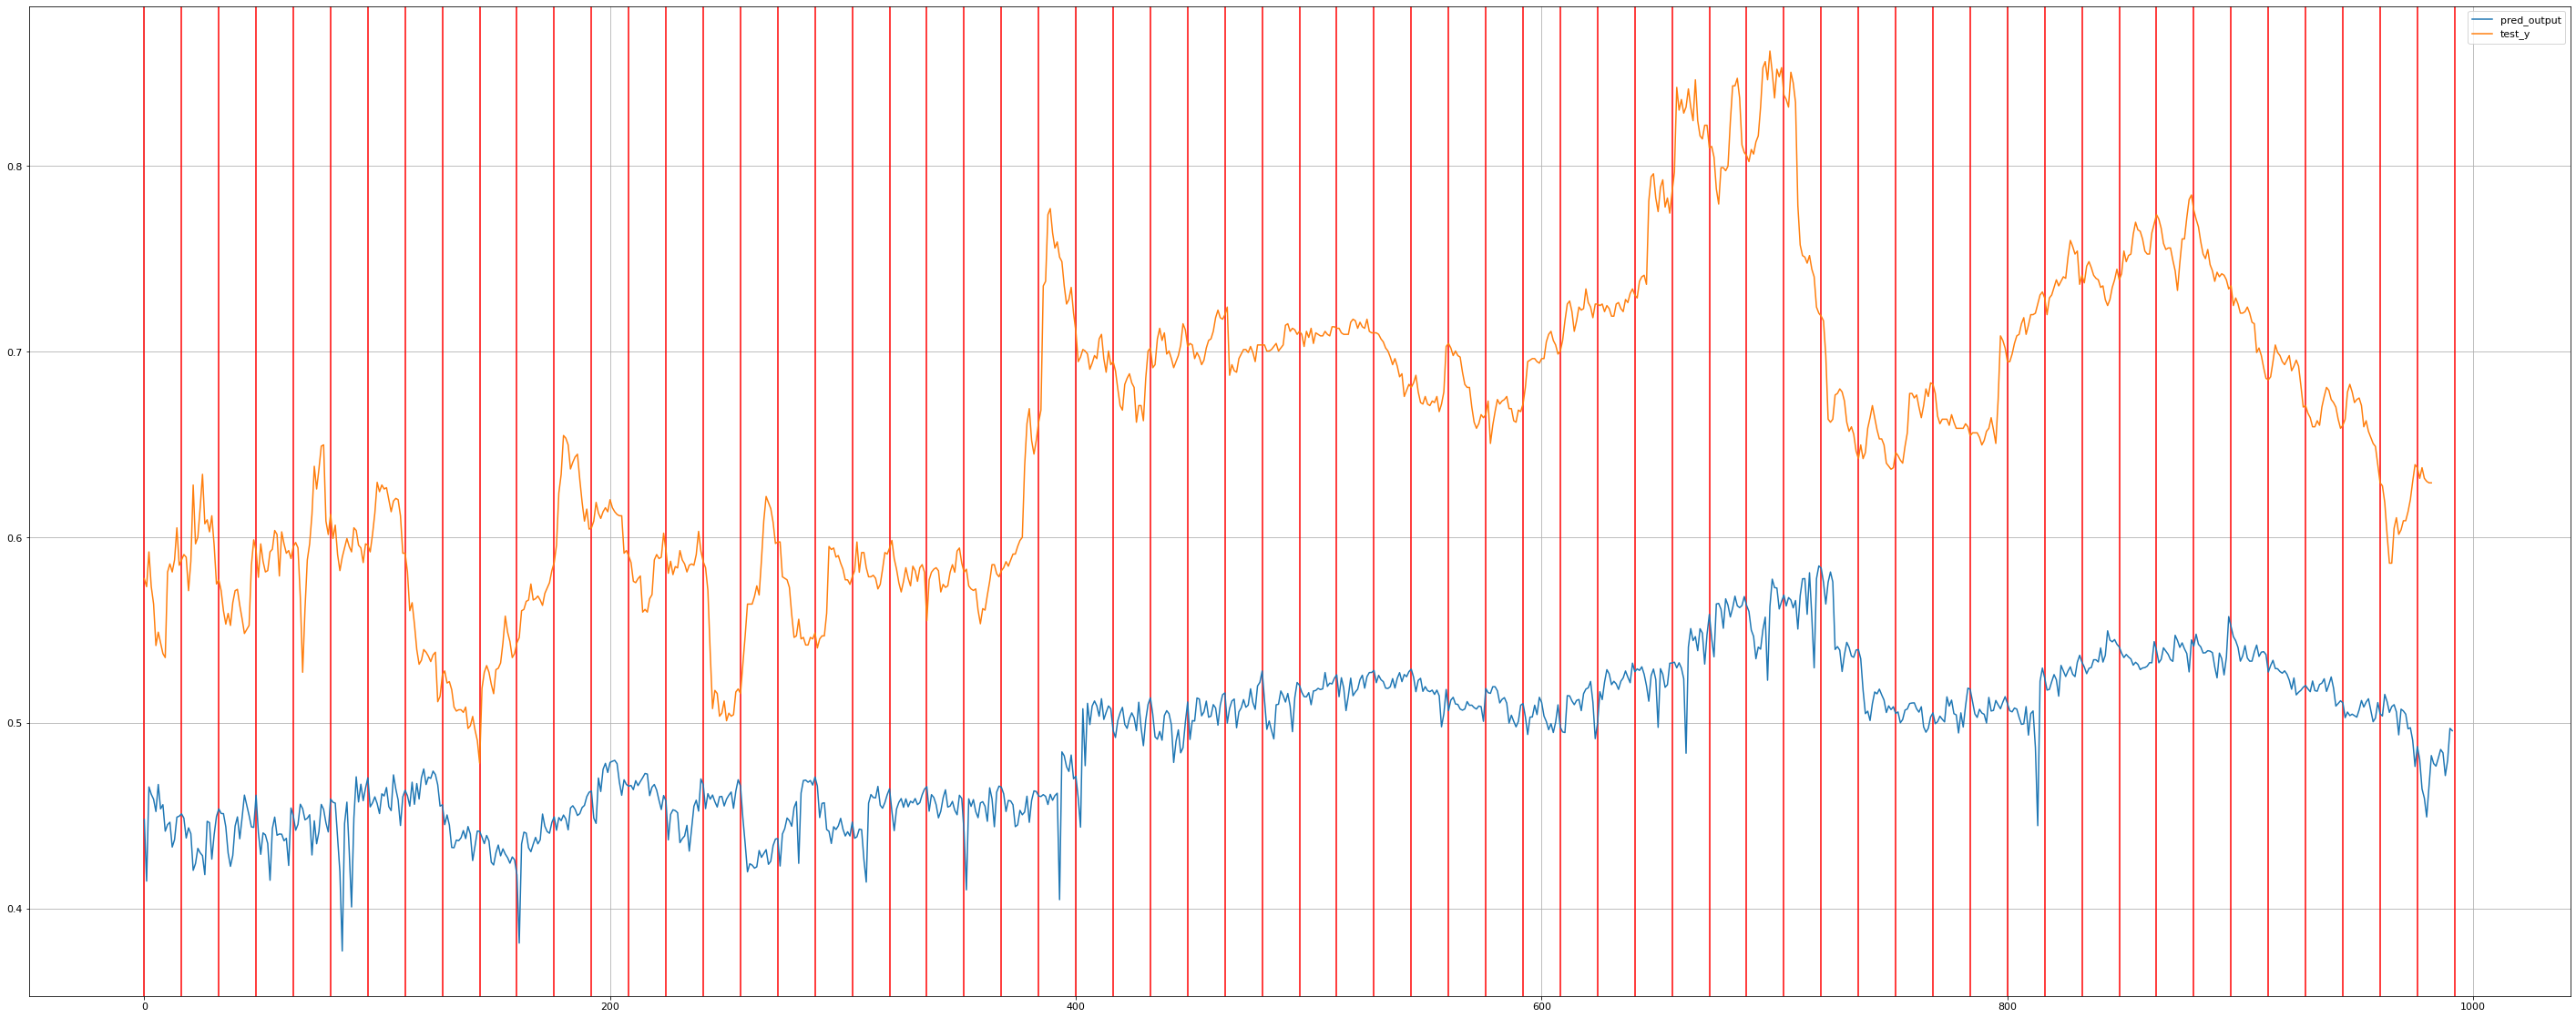

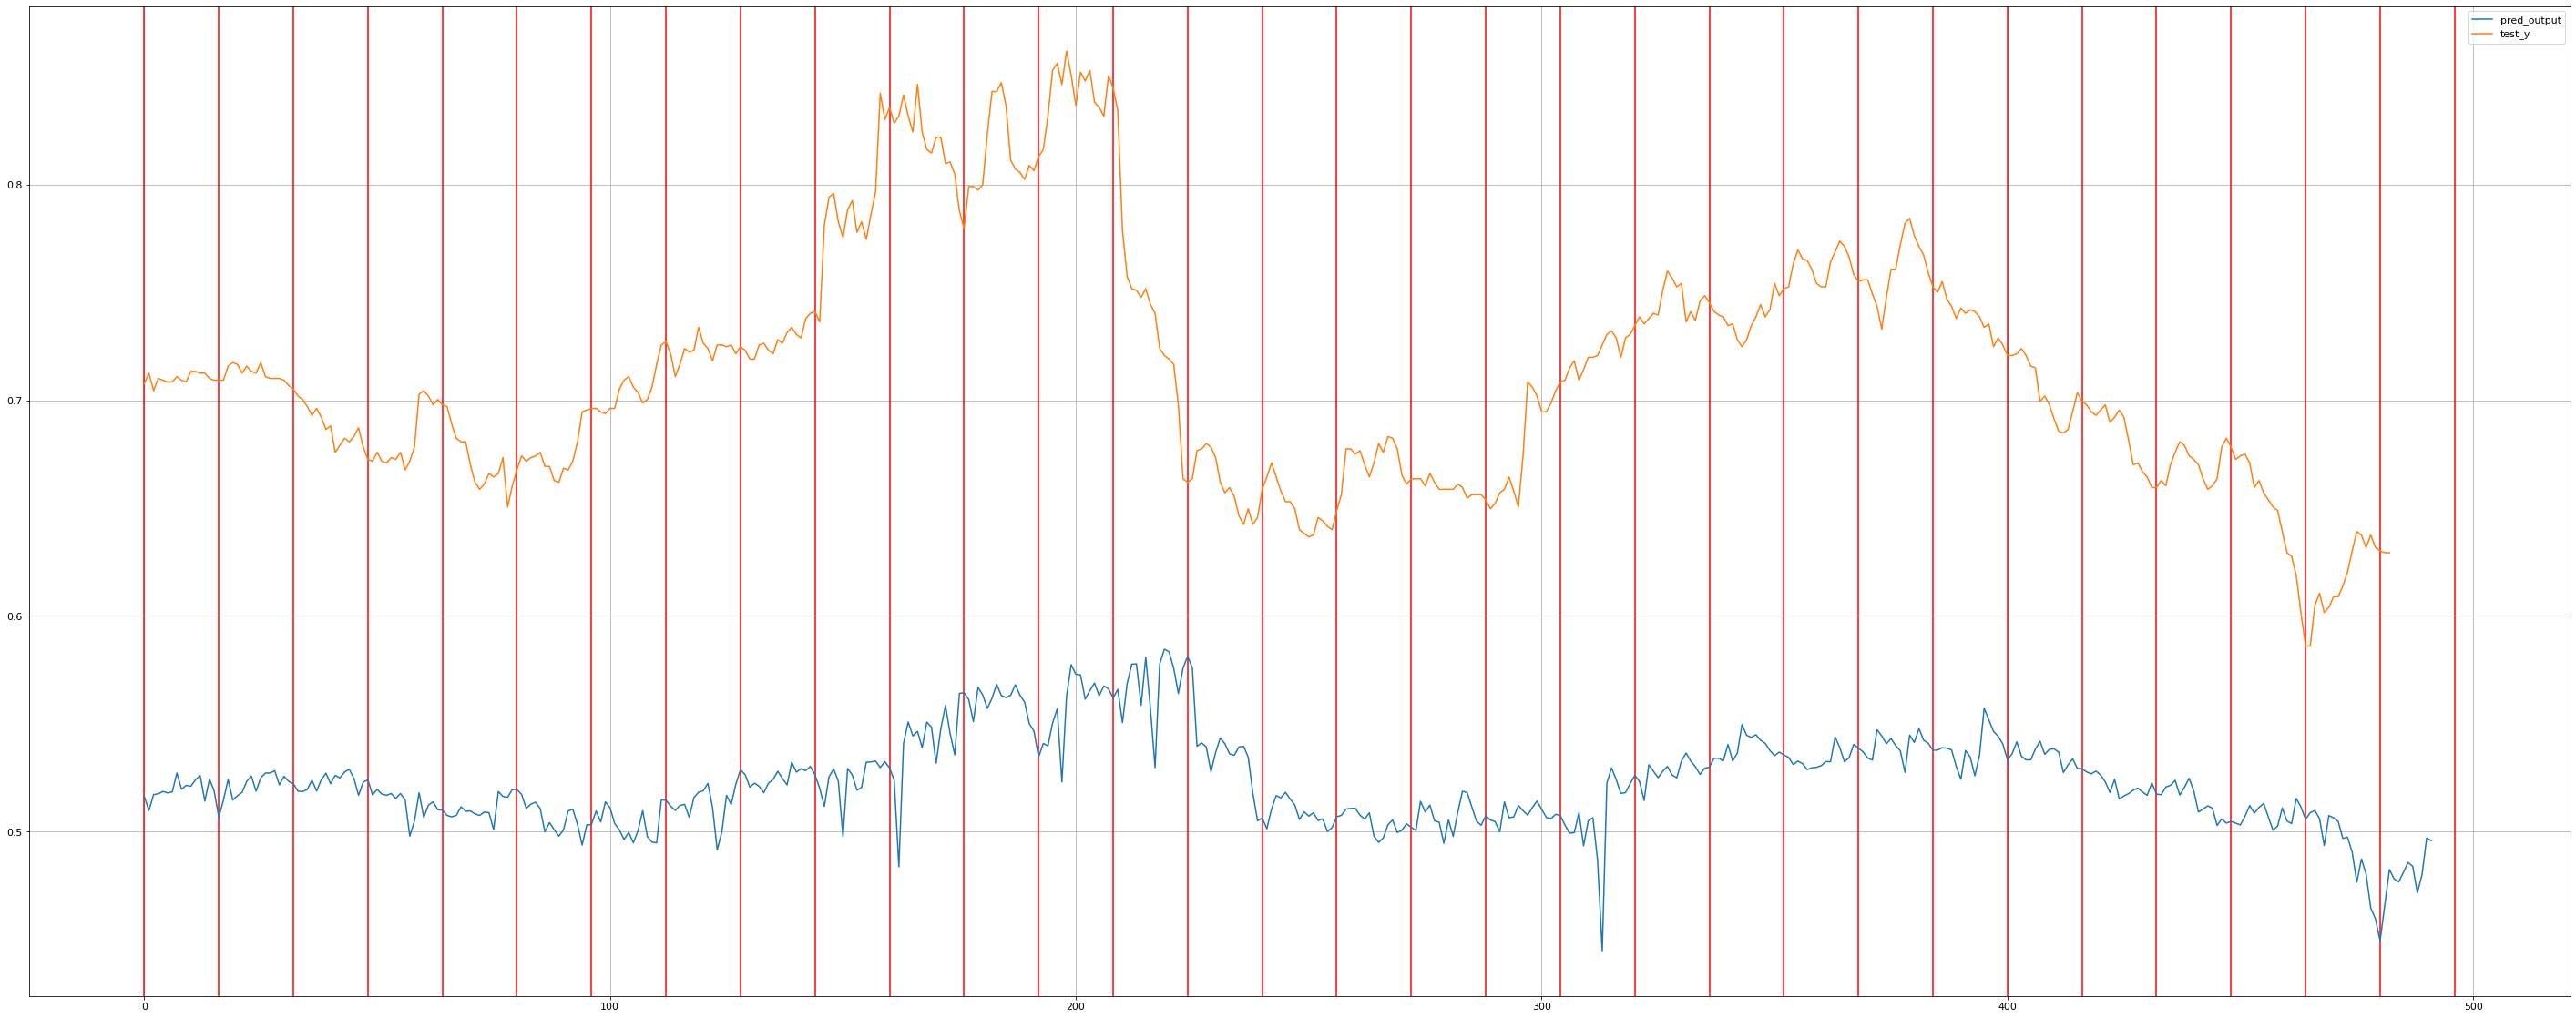

In [22]:
plt.rcParams['figure.figsize'] = (50,20) #6，8分别对应宽和高
# final_result = np.array(result)
# print("final_result",final_result.shape)
# true_y = np.array(true)
# print("true_y",true_y.shape)


# mse = mean_squared_error(result, true_y)
# rmse = math.sqrt(mean_squared_error(result, true_y))
# mae = mean_absolute_error(result, true_y)
# print('mean_squared_error:%.6f' % mse)
# print('root_mean_squared_error:%.6f' % rmse)
# print('mean_absolute_error:%.6f' % mae)

# output = output.cpu()
# plt.plot(output.data.numpy().reshape(trainX.shape[0], 1), label='predicted_output')
# plt.plot(trainy.reshape(trainy.shape[0], 1), label='train_y')
# plt.grid(True)
# plt.axis('tight')
# plt.legend()
# plt.show()
for x in range(0,1000,16):
    plt.axvline(x, 0, 1,color="red")#横线
plt.plot(final_result, label='pred_output')
plt.plot(true_y, label='test_y')
plt.legend()
plt.grid(True)
plt.axis('tight')
plt.show()



# plt.plot(true_y, label='test_y')
# plt.plot(final_result, label='pred_output')
# plt.plot(true_y, label='test_y')
# plt.legend()
# plt.grid(True)
# plt.axis('tight')
# plt.show()

segmentx = final_result[500:,:]
segmenty = true_y[500:,:]
for x in range(0,500,16):
    plt.axvline(x, 0, 1,color="red")#横线
plt.plot(segmentx, label='pred_output')
plt.plot(segmenty, label='test_y')
plt.legend()
plt.grid(True)
plt.axis('tight')
plt.show()

In [14]:
# #!/usr/bin/python
# # -*- coding: UTF-8 -*-
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split
# import os
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import torch
# import torch.nn as nn
# from torch.autograd import Variable
# import torch.optim as optim
# import random
# import time
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import math
# from tqdm import trange
# from torch.utils.data import DataLoader, Dataset
# from torchvision import transforms
# import tensorflow as tf
# import matplotlib.pyplot as plt


# date=4200
# model_name = "Mini-Pytorch"
# torch.manual_seed(1)
# input_size = 7
# hidden_size = 1024
# output_size = 1
# epoch = 1
# lr = 1e-4
# seqs = 5
# dim_in = 7
# dim_out = 1
# time_steps = 5
# smoothing_window_size = 100

# for par in [5000]:
#     for par2 in [50]:
#         smoothing_window_size = par2
#         time_steps = 5
#         date = 2000
#         product = "SQJT1125"
#         df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/min_600104data1129.csv")
#         df = df.drop(labels=['symbol', 'frequency', 'Unnamed: 0', 'eob', 'position', 'pre_close'], axis=1)
#         data = df.sort_values(['bob'], ascending=True)
#         # data = data[:-1]
#         data = data[par:]
#         data['mid'] = (data['high'].values + data['low'].values) / 2
#         data = data[['mid','open', 'high', 'low', 'close', 'volume', 'amount', 'bob']]
#         data = data.sort_values(['bob'], ascending=True)
#         data = data.drop(labels=['bob'], axis=1)
#         train_data = data[int(data.shape[0]*0.2):]
#         test_data = data[:int(data.shape[0] * 0.2)]
#         #draw
#         plt.rc('font', family='Youyuan', size='11')  # 和matplotlib一样指明字体
#         plt.rc('axes', unicode_minus='False')
#         pdseries = pd.Series(train_data['mid'].values)
#         plt.title('Train stock')  # 设置中文标题
#         pdseries.plot()
#         plt.show()

#         train_data = train_data.values.astype('float32')
#         test_data = test_data.values.astype('float32')
#         #entire fit
#         scaler = MinMaxScaler()
#         scaler.fit(train_data)
#         train_data = scaler.transform(train_data)
#         test_data = scaler.transform(test_data)


#         # 根据原始数据集构建矩阵
#         def create_dataset_trans(data, time_steps1,time_steps2,time_steps3):
#             dataX1, dataX2 ,dataY = [], [], []
#             for i in range(len(data) - (time_steps1+time_steps2+time_steps3-3)):
#               a = data[i:(i + time_steps1), :]
#               b = data[(i + time_steps1-1):(i + time_steps1+time_steps2-1), 1:7]
#               c = data[(i + time_steps1+time_steps2-2):(i + time_steps1+time_steps2+time_steps3-2), 0:1]
#               dataX1.append(a)
#               dataX2.append(b)
#               dataY.append(c)
#             dataX1 = np.array(dataX1)
#             dataX2 = np.array(dataX2)
#             dataY = np.array(dataY)
#             return dataX1, dataX2 ,dataY 

#         trainX,trainX_decoder,trainY = create_dataset_trans(train_data,16,16,16)
#         testX,testX_decoder,testY = create_dataset_trans(test_data,16,16,16)

#         print('-' * 10 + 'train/test' + '-' * 10)
        
#         print("trainX:",trainX.shape)
#         print("trainX_decoder:",trainX_decoder.shape)
#         print("trainY:",trainY.shape)
        
#         print("testX:",testX.shape)
#         print("testX_decoder:",testX_decoder.shape)
#         print("testY:",testY.shape)
  

#         from torch.utils.data import TensorDataset
#         import torch
#         from torch.utils.data import DataLoader

#         dl_train = DataLoader(TensorDataset(torch.tensor(trainX).float(), torch.tensor(trainY).float(), torch.tensor(trainX_decoder).float()),
#                               shuffle=False, batch_size=128)
#         dl_valid = DataLoader(TensorDataset(torch.tensor(testX).float(), torch.tensor(testY).float(), torch.tensor(testX_decoder).float()),
#                               shuffle=False, batch_size=128)



        
#         print(trainX.shape)
#         bp = TimeSeriesForcasting(n_encoder_inputs=7, n_decoder_inputs=6)
#         device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#         bp = bp.to(device)
#         # summary(bp,input_size=(5,7),batch_size=-1)
#         # trainx = trainX.to(device)
#         # trainy = trainY.to(device)
#         # testx = testX.to(device)
#         # testy = testY.to(device)
#         # trainX_decoder = trainX_decoder.to(device)
#         # trainY_decoder = trainY_decoder.to(device)
#         # testX_decoder = testX_decoder.to(device)
#         # testY_decoder = testY_decoder.to(device)

#         loss_function = nn.MSELoss()
#         optimizer = optim.Adam(bp.parameters(), lr)

#         list_x = []
#         list_y = []
#         list_ax = []
#         list_ay = []

#         begin = time.time()

#         for epoch in trange(epoch):
#             for batch_idx,(data_dl, target_dl, train_decoder_dl) in enumerate(dl_train):
#                 data_dl, target_dl, train_decoder_dl = data_dl.to(device) , target_dl.to(device), train_decoder_dl.to(device)
#                 # print(data_dl.shape)
#                 # print(target_dl.shape)
#                 # print(train_decoder_dl.shape)
#                 init_states = None
#                 output = bp((data_dl,train_decoder_dl))
#                 loss = loss_function(output, target_dl)
#                 running_loss = loss.item()
#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()
#                 Loss = []

#                 list_x.append(epoch)
#                 list_y.append(loss.item())

#                 # if epoch == 10:
#                 #     list_ax.append(epoch)
#                 #     list_ay.append(loss.item())
#                 #     plt.plot(list_x, list_y, color='r', linewidth=3)
#                 #     plt.scatter(list_ax, list_ay, marker='*', color='r')
#                 #     plt.show()

#                 # if epoch % 10 == 0:
#                 #     Loss.append(running_loss)
#                 #     print('Epoch: {}, Loss:{:.5f}, learning rate:{}'.format(epoch + 1, loss.item(), 1e-4))

#         pass
        

#         data_dl, target_dl, train_decoder_dl = data_dl.cpu() , target_dl.cpu(), train_decoder_dl.cpu()
#         output = output.cpu()


#         time_elapsed = time.time() - begin
#         print('Training Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

#         bp = bp.eval()

#         '''
#         pre_output torch.Size([128, 16, 1])
#         pre_output torch.Size([128, 16, 1])
#         pre_output torch.Size([11, 16, 1])
#         final_result (6155, 1)
#         true_y (6155, 1)
#         '''
#         result =[]
#         true =[]
#         for batch_idx, (test_dl, valid_dl, test_decoder_dl) in enumerate(dl_valid):
#             init_states = None
#             test_dl, valid_dl, test_decoder_dl = test_dl.to(device), valid_dl.to(device), test_decoder_dl.to(device)
            
#             if(batch_idx%16==0):
#               pre_output = bp((test_dl,test_decoder_dl))
#               print("pre_output",pre_output.shape)

#               for num in range(0,16):
#                 result_iter = pre_output [:,num:num+1,:]
#                 result_iter =result_iter.cpu()
#                 result_iter = result_iter.data.numpy().reshape(pre_output.shape[0],1)
#                 for i in result_iter:
#                     result.append(i)


#             true_iter = valid_dl[:, 0:1, :]
#             true_iter = true_iter.cpu()
#             true_iter = true_iter.data.numpy().reshape(true_iter.shape[0], 1)
#             for i in true_iter:
#                 true.append(i)

#         final_result = np.array(result)
#         print("final_result",final_result.shape)
#         true_y = np.array(true)
#         print("true_y",true_y.shape)

#         # mse = mean_squared_error(result, true_y)
#         # rmse = math.sqrt(mean_squared_error(result, true_y))
#         # mae = mean_absolute_error(result, true_y)
#         # print('mean_squared_error:%.6f' % mse)
#         # print('root_mean_squared_error:%.6f' % rmse)
#         # print('mean_absolute_error:%.6f' % mae)

#         # output = output.cpu()
#         # plt.plot(output.data.numpy().reshape(trainX.shape[0], 1), label='predicted_output')
#         # plt.plot(trainy.reshape(trainy.shape[0], 1), label='train_y')
#         # plt.grid(True)
#         # plt.axis('tight')
#         # plt.legend()
#         # plt.show()

#         plt.plot(final_result, label='pred_output')
#         plt.plot(true_y, label='test_y')
#         plt.legend()
#         plt.grid(True)
#         plt.axis('tight')
#         plt.show()
#         #
#         # # with open("predict.csv", "w") as my_empty_csv:
#         # new=pd.DataFrame({'product':product,
#         #                   'model':model_name,
#         #                   'epoch':epoch,
#         #                   'learning rate':lr,
#         #                   'hidden_size':hidden_size,
#         #                   'input_size':input_size,
#         #                   'mean_squared_error':mse,
#         #                   'root_mean_squared_error':rmse,
#         #                   'mean_absolute_error':mae,
#         #                   },index=[0])   # 自定义索引为：1 ，这里也可以不设置index
#         # new.to_csv("上汽集团predict.csv")
#         # record = pd.read_csv("上汽集团predict.csv",index_col=0)
#         # record = record.append([{'product':product,
#         #                   'model':model_name,
#         #                   'epoch':epoch,
#         #                   'learning rate':lr,
#         #                   'hidden_size':hidden_size,
#         #                   'input_size':input_size,
#         #                   'mean_squared_error':mse,
#         #                   'root_mean_squared_error':rmse,
#         #                   'mean_absolute_error':mae,
#         #                 'predict':result,
#         #                 'date':date,
#         #                 'time_step':time_steps,
#         #                          'smoothing_window_size':smoothing_window_size,
#         #
#         #                   }],ignore_index=True)
#         # record.to_csv("上汽集团predict.csv")
